In [1]:
import requests, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk import bigrams, trigrams
from sklearn.feature_extraction.text import CountVectorizer
from textstat import flesch_reading_ease # exploring text complixity
# for sentiment analysis
from textblob import TextBlob
import spacy
# for clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# feature importance of clustering 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
folder_path = 'data'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for i in ['train.jsonl', 'test.jsonl', 'validation.jsonl']:
    filename = os.path.join(folder_path, i)
    if os.path.exists(filename):
        print(f" File {filename} already exists.")
    else:
        url = "https://github.com/DenisPeskov/2020_acl_diplomacy/raw/master/data/"+i
        response = requests.get(url)
        if response.status_code == 200:
            with open(filename, 'wb') as file:
                file.write(response.content)
            print(f"File '{filename}' has been downloaded and saved to '{folder_path}'.")
            # join all three files into a file for feature extraction, EDA and cleaning 
            with open(folder_path + '/all_data.jsonl', 'ab') as file:
                file.write(response.content)
            print(f"File '{filename}' added to all_data file.")
        else:
            print(f"Failed to download {url}. Status code: {response.status_code}")
    

 File data\train.jsonl already exists.
 File data\test.jsonl already exists.
 File data\validation.jsonl already exists.


In [3]:
df=pd.read_json('data/all_data.jsonl', lines=True)
df.head(2)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1


In [4]:
game_ids = []
senders = []
receivers = []
messages = []
sender_labels = []
receiver_labels = []
scores = []

for i, j in df.iterrows():       
    for c, d in enumerate(j['messages']):
        #print(c)
        game_ids.append(j['game_id'])
        senders.append(j['speakers'][c])
        receivers.append(j['receivers'][c])
        messages.append(j['messages'][c])
        sender_labels.append(j['sender_labels'][c])
        receiver_labels.append(j['receiver_labels'][c])
        scores.append(j['game_score'][c])
        
new_df = pd.DataFrame({'game_id': game_ids, 'sender': senders, 'receiver' : receivers, 'message': messages ,
                       'sender_label': sender_labels, 'receiver_label': receiver_labels, 'score': scores })
new_df

,game_id,sender,receiver,message,sender_label,receiver_label,score
0,1,italy,germany,Germany!\n\nJust the person I want to speak wi...,True,True,3
1,1,germany,italy,"You've whet my appetite, Italy. What's the sug...",True,True,3
2,1,italy,germany,👍,True,True,3
3,1,germany,italy,It seems like there are a lot of ways that cou...,True,True,3
4,1,italy,germany,"Yeah, I can’t say I’ve tried it and it works, ...",True,NOANNOTATION,3
...,...,...,...,...,...,...,...
17284,11,france,turkey,You and Austria are the most importand. Italy ...,False,NOANNOTATION,8
17285,11,france,turkey,"Hello, Turkey?",True,NOANNOTATION,8
17286,11,france,turkey,Hello???,True,NOANNOTATION,8
17287,11,france,turkey,"Helloooo, turkey",True,NOANNOTATION,8


In [5]:
new_df[new_df['game_id'] == 5 ]

,game_id,sender,receiver,message,sender_label,receiver_label,score
7834,5,germany,italy,"So, Austria crossed some lines we'd negotiated...",True,True,4
7835,5,austria,italy,Hello Italy! I chose you as the first country ...,True,True,3
7836,5,austria,italy,"All right I see how it works now :).\nAnyways,...",True,True,3
7837,5,austria,italy,I firmly believe that Italy/Austria is one of ...,True,True,3
7838,5,austria,italy,I happily await your response :),True,True,3
...,...,...,...,...,...,...,...
8256,5,turkey,france,Of course I can choose to develop north instea...,True,True,10
8257,5,france,turkey,How can I entice you to do that?,True,True,12
8258,5,france,turkey,Are you on board for a 3 way draw?,True,True,10
8259,5,turkey,france,I'm confused. What is there to gain through a ...,True,True,11


In [6]:
def text_preprocess(message):
    processed = []   
    for text in message:
        # replaace URLs
        text = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)",'URL',text)  
        
        # Replace all non alphabets.
        #text = re.sub( "[^a-zA-Z0-9]", " ", text)  # this will replace emojies as well!
        
        # Remove HTML/XML tags (if any)
        text = re.sub(r'<.*?>', '', text)

        # Remove punctuation and symbols -- (not for now)
        # text = re.sub(r'[^\w\s]', '', text) 

        # Remove numbers -- not for now
        #text = re.sub(r'\d+', '', text)

        # Remove whitespaces (including new lines and tabs)
        text = text.strip().replace("\n", " ").replace("\r", " ").replace("\t", " ")
        
        processed.append(text)       
    return processed

new_df['processed_message'] = text_preprocess(list(new_df['message']))

In [7]:
new_df[new_df['processed_message'] == 'URL']

,game_id,sender,receiver,message,sender_label,receiver_label,score,processed_message
3112,2,italy,austria,https://www.stitcher.com/podcast/diplomacy-gam...,True,True,3,URL
3137,2,austria,italy,https://diplomacy.fandom.com/wiki/The_Blue_Wat...,True,True,3,URL
3164,2,austria,italy,https://discord.gg/P5vyvz8,True,True,3,URL
4323,2,austria,germany,https://discord.gg/P5vyvz8,True,True,5,URL
5491,2,austria,russia,https://discord.gg/P5vyvz8,True,True,5,URL
6819,3,germany,england,https://m.youtube.com/watch?v=VBmMU_iwe6U,True,True,3,URL
8328,6,germany,england,https://www.backstabbr.com/sandbox/62031255626...,True,True,3,URL
8600,6,austria,turkey,https://tenor.com/view/turkey-slice-cut-thanks...,True,True,3,URL
9891,8,russia,italy,https://tenor.com/view/why-huh-but-why-gif-131...,True,NOANNOTATION,5,URL
10353,8,russia,turkey,https://media.tenor.com/images/d74df5ad5b63cc9...,True,NOANNOTATION,5,URL


---

In [8]:
new_df['score'].value_counts()

5     4623
3     3250
4     2831
6     2226
7     1724
8      685
10     614
9      542
11     323
12     174
2       94
13      73
15      43
1       42
0       19
14      17
17       9
Name: score, dtype: int64

In [9]:
#max_score = new_df.query('game_id == 1 ')['score'].min()
new_df.query('game_id == 1')[['sender', 'receiver','processed_message', 'score', 'sender_label', 'receiver_label']]

,sender,receiver,processed_message,score,sender_label,receiver_label
0,italy,germany,Germany! Just the person I want to speak with...,3,True,True
1,germany,italy,"You've whet my appetite, Italy. What's the sug...",3,True,True
2,italy,germany,👍,3,True,True
3,germany,italy,It seems like there are a lot of ways that cou...,3,True,True
4,italy,germany,"Yeah, I can’t say I’ve tried it and it works, ...",3,True,NOANNOTATION
...,...,...,...,...,...,...
2613,france,turkey,"Hi turkey, how do you feel about your neighbor...",3,True,True
2614,turkey,france,Well yeah depends on the neighbors,3,True,True
2615,france,turkey,Any additional thoughts after negotiations by ...,3,True,True
2616,turkey,france,No not yet everyone seems rather tepid,3,True,True


In [10]:
new_df['score'] = pd.to_numeric(new_df['score'], errors='coerce')

In [11]:
game_id = 2
max_score = new_df.query('game_id == @game_id')['score'].max()

In [12]:
#new_df.query('game_id == @game_id and score==@max_score')

<Axes: xlabel='sender', ylabel='count'>

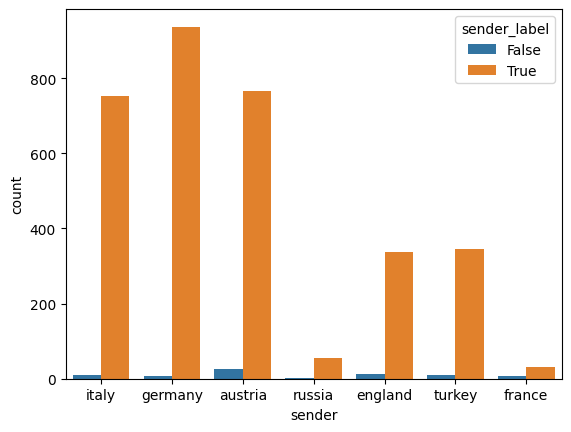

In [13]:
sns.countplot(data=new_df.query('game_id == @game_id'), x='sender', hue='sender_label')

<Axes: xlabel='sender', ylabel='count'>

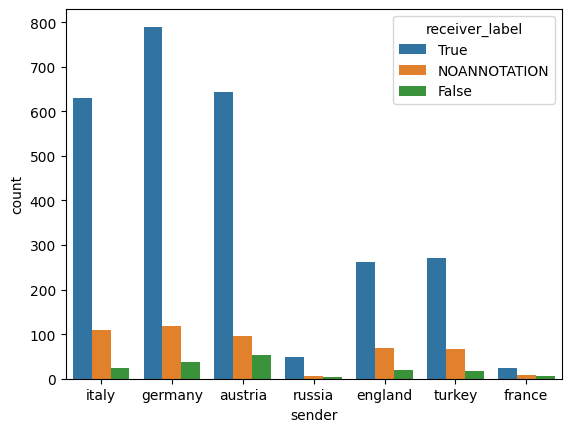

In [14]:
sns.countplot(data = new_df.query('game_id == @game_id'), x='sender', hue='receiver_label')

<Axes: xlabel='sender', ylabel='score'>

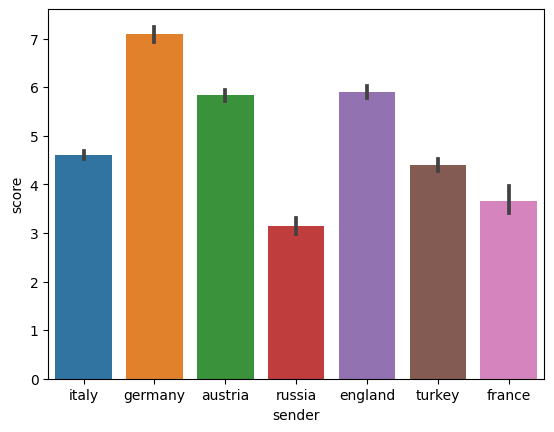

In [15]:
sns.barplot(data = new_df.query('game_id == @game_id'), x='sender', y='score')

---
## Feature Extraction:

+ number of words in the sentence
+ frequency of functional words in the sentence
+ frequency of certain Parts-of-Speech (PoS) tags in the sentence such as:
+ + frequency of pronouns (total, first person, second person, third person)
+ + negations (e.g. use of "not"-type words)
+ + frequency of articles
+ + frequency of prepositions
+ frequency of certain N-grams in the sentence
+ sentence complexity.

+ frequency of words used found in some curated, potentially domain-specific dictionary
+ frequency of words of length > 6
+ sentiment
+ certainty (from self-doubting to absolutely certain)
+ implied causality
+ inclusivity/exclusivity
+ frequency of motion verbs
+ frequency of past tense verbs
+ frequency of future tense verbs
+ word/sentence embeddings (from e.g. bert-base encoder).

---
#### number of words in the sentence

In [16]:
new_df['num_words_sentence'] = new_df['processed_message'].apply(lambda x: len(x.split()))
new_df[['processed_message' , 'num_words_sentence']]

,processed_message,num_words_sentence
0,Germany! Just the person I want to speak with...,87
1,"You've whet my appetite, Italy. What's the sug...",8
2,👍,1
3,It seems like there are a lot of ways that cou...,31
4,"Yeah, I can’t say I’ve tried it and it works, ...",127
...,...,...
17284,You and Austria are the most importand. Italy ...,74
17285,"Hello, Turkey?",2
17286,Hello???,1
17287,"Helloooo, turkey",2


---
#### frequency of functional words in the sentence --> (stop words!?)

In [17]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def count_stop_words(sentence):
    words = sentence.split()
    stop_words_in_sentence = [word for word in words if word.lower() in stop_words]
    return len(stop_words_in_sentence)

new_df['stop_words_count'] = new_df['processed_message'].apply(count_stop_words)
new_df[['processed_message' , 'stop_words_count']]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,processed_message,stop_words_count
0,Germany! Just the person I want to speak with...,36
1,"You've whet my appetite, Italy. What's the sug...",3
2,👍,0
3,It seems like there are a lot of ways that cou...,13
4,"Yeah, I can’t say I’ve tried it and it works, ...",58
...,...,...
17284,You and Austria are the most importand. Italy ...,41
17285,"Hello, Turkey?",0
17286,Hello???,0
17287,"Helloooo, turkey",0


---
#### frequency of certain Parts-of-Speech (PoS) tags in the sentence

In [18]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

#Noun (NN)
#Verb (VB)
#Adjective(JJ)
#Adverb(RB)
#Preposition (IN)
#Conjunction (CC)
#Pronoun(PRP)
#Interjection (INT)

# here i get all pos!
# the result of this function would be json which wont be really useful as a feature
def pos_tag_frequency(sentence):
    words = word_tokenize(sentence)
    pos_tags = nltk.pos_tag(words)
    #select the second element in each tuple
    tags = [tag for word, tag in pos_tags if tag == 'PRP']
    tag_freq = Counter(tags)
    return tag_freq

#new_df['pos_tag_freq'] = new_df['processed_message'].apply(pos_tag_frequency)
#new_df[['processed_message' , 'pos_tag_freq']]

pron_freq = []
article_freq = []
prep_freq = []
adj_freq = []

for i, j in new_df.iterrows():       
    words = word_tokenize(j['processed_message'])
    pos_tags = nltk.pos_tag(words)
    pron_freq.append(len([tag for word, tag in pos_tags if tag == 'PRP']))
    article_freq.append(sum([1 for word in words if word.lower() in ['the', 'a', 'an']]))
    prep_freq.append(len([tag for word, tag in pos_tags if tag == 'IN']))
    adj_freq.append(len([tag for word, tag in pos_tags if tag == 'JJ']))
        
new_df['pron_freq'] = pron_freq
new_df['article_freq'] = article_freq
new_df['prep_freq'] = prep_freq
new_df['adj_freq'] = adj_freq


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [19]:
new_df[['processed_message' , 'pron_freq', 'article_freq', 'prep_freq', 'adj_freq']]

,processed_message,pron_freq,article_freq,prep_freq,adj_freq
0,Germany! Just the person I want to speak with...,12,6,7,14
1,"You've whet my appetite, Italy. What's the sug...",1,1,0,0
2,👍,0,0,0,0
3,It seems like there are a lot of ways that cou...,5,1,4,2
4,"Yeah, I can’t say I’ve tried it and it works, ...",25,3,14,3
...,...,...,...,...,...
17284,You and Austria are the most importand. Italy ...,6,2,8,1
17285,"Hello, Turkey?",0,0,0,0
17286,Hello???,0,0,0,0
17287,"Helloooo, turkey",0,0,0,0


---
#### frequency of certain N-grams in the sentence

In [20]:
# should actually check how many of top n-grams each sentenc contains?

In [21]:
#identify the top N n-grams from text
def get_top_ngram(corpus, n=None, m=20):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]       
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:m]

In [22]:
top_n_bigrams=get_top_ngram(new_df['processed_message'],2)
top_n_bigrams

[('if you', 1320),
 ('in the', 1175),
 ('going to', 891),
 ('you re', 761),
 ('to be', 691),
 ('want to', 667),
 ('do you', 623),
 ('you can', 570),
 ('we can', 553),
 ('would be', 515),
 ('need to', 469),
 ('to do', 458),
 ('to get', 454),
 ('are you', 447),
 ('of the', 442),
 ('that you', 437),
 ('you and', 431),
 ('you have', 419),
 ('me to', 412),
 ('on the', 411)]

In [23]:
top_n_trigrams=get_top_ngram(new_df['processed_message'],3)
top_n_trigrams

[('be able to', 239),
 ('do you think', 201),
 ('you want to', 199),
 ('what do you', 190),
 ('let me know', 162),
 ('if you re', 158),
 ('in the fall', 144),
 ('support you into', 144),
 ('to work with', 142),
 ('at this point', 137),
 ('if you want', 131),
 ('in the north', 127),
 ('going to be', 119),
 ('do you want', 115),
 ('don want to', 112),
 ('the north sea', 111),
 ('it would be', 110),
 ('we need to', 110),
 ('what are your', 106),
 ('is going to', 104)]

In [24]:
# check if the sentence includes top bigrams or trigrams:
top_bigrams = [i[0] for i in top_n_bigrams]
top_trigrams =  [i[0] for i in top_n_trigrams]

def count_ngrams(sentence, n):
    words = word_tokenize(sentence)
    separator = ' '
    if n == 2:
        n_grams = sum([1 if separator.join(i) in top_bigrams else 0 for i in list(bigrams(words))])
    elif n == 3:
        n_grams = sum([1 if separator.join(i) in top_trigrams else 0 for i in list(trigrams(words))])
    else:
        return 0
    return n_grams

new_df['top_bigram_freq'] = new_df['processed_message'].apply(lambda x: count_ngrams(x, 2))
new_df['top_trigram_freq'] = new_df['processed_message'].apply(lambda x: count_ngrams(x, 3))

In [25]:
new_df[['processed_message' , 'top_bigram_freq' , 'top_trigram_freq']]

,processed_message,top_bigram_freq,top_trigram_freq
0,Germany! Just the person I want to speak with...,1,0
1,"You've whet my appetite, Italy. What's the sug...",0,0
2,👍,0,0
3,It seems like there are a lot of ways that cou...,0,0
4,"Yeah, I can’t say I’ve tried it and it works, ...",2,0
...,...,...,...
17284,You and Austria are the most importand. Italy ...,6,1
17285,"Hello, Turkey?",0,0
17286,Hello???,0,0
17287,"Helloooo, turkey",0,0


In [26]:
new_df[new_df['top_trigram_freq'] > 0]

,game_id,sender,receiver,message,sender_label,receiver_label,score,processed_message,num_words_sentence,stop_words_count,pron_freq,article_freq,prep_freq,adj_freq,top_bigram_freq,top_trigram_freq
12,1,italy,germany,"Well, at least I have an idea of who to trust....",True,True,3,"Well, at least I have an idea of who to trust....",116,57,10,10,13,8,1,1
25,1,italy,germany,How are things going with England? I think tha...,True,True,4,How are things going with England? I think tha...,20,11,3,1,3,1,0,1
47,1,italy,germany,Two bits of advice: #1 I suggest you tell Russ...,True,NOANNOTATION,6,Two bits of advice: #1 I suggest you tell Russ...,88,42,15,1,8,3,2,2
48,1,italy,germany,#2 Here is the move set I would suggest right ...,True,NOANNOTATION,6,#2 Here is the move set I would suggest right ...,82,37,9,1,7,1,1,1
51,1,germany,italy,I think me and England are really on the same ...,True,True,4,I think me and England are really on the same ...,66,33,7,3,11,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17228,11,turkey,russia,"Well, I have no issue with you guaranteeing yo...",True,NOANNOTATION,4,"Well, I have no issue with you guaranteeing yo...",58,31,11,3,5,2,2,1
17251,11,france,russia,Germany is going to move into sweden with engl...,True,NOANNOTATION,6,Germany is going to move into sweden with engl...,17,5,0,0,2,2,1,1
17256,11,france,england,"Hey England, how are you? I would like to disc...",False,True,3,"Hey England, how are you? I would like to disc...",81,39,11,5,6,6,4,1
17265,11,england,france,how do you feel about supporting me into the n...,True,True,2,how do you feel about supporting me into the n...,11,7,2,1,2,1,1,1


---
#### sentence complexity

In [27]:
# flesch_reading_ease => 206.835 - 1.015 * (total_words / total_sentences) - 84.6 * (total_syllables / total_words)
new_df['text_ease'] = new_df['processed_message'].apply(lambda x : flesch_reading_ease(x))
new_df[new_df['text_ease']== new_df['text_ease'].max()]

,game_id,sender,receiver,message,sender_label,receiver_label,score,processed_message,num_words_sentence,stop_words_count,pron_freq,article_freq,prep_freq,adj_freq,top_bigram_freq,top_trigram_freq,text_ease
2,1,italy,germany,👍,True,True,3,👍,1,0,0,0,0,0,0,0,206.84
143,1,italy,germany,🤗,True,True,8,🤗,1,0,0,0,0,0,0,0,206.84
197,1,italy,germany,👍,True,True,10,👍,1,0,0,0,0,0,0,0,206.84
232,1,italy,germany,👍,True,True,10,👍,1,0,0,0,0,0,0,0,206.84
349,1,italy,austria,🤗,True,True,5,🤗,1,0,0,0,0,0,0,0,206.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16369,11,austria,germany,?,True,True,3,?,1,0,0,0,0,0,0,0,206.84
16421,11,austria,germany,😂,True,True,4,😂,1,0,0,0,0,0,0,0,206.84
16665,11,england,germany,😔,True,True,2,😔,1,0,0,0,0,0,0,0,206.84
16862,11,france,germany,🤷‍♂️,True,True,8,🤷‍♂️,1,0,0,0,0,0,0,0,206.84


linguistic complexity is a broad field and there are many other factors could be considered, like the use of passive voice, nominalizations, advanced punctuation, lexical density, and so on.

In [28]:
#frequency of words used found in some curated, potentially domain-specific dictionary
# This is challenging, which domain should be explored??
# wordnet from nltk.corpus might be useful if know which domain we are exploring!

In [29]:
#frequency of words of length > 6
#get the number of words longer than 6 in each message
new_df['num_long_words'] = new_df['processed_message'].str.split().apply(lambda x : [1 if len(i) > 6 else 0 for i in x]).map(lambda x: sum(x))
new_df[['processed_message' , 'num_long_words']]

,processed_message,num_long_words
0,Germany! Just the person I want to speak with...,15
1,"You've whet my appetite, Italy. What's the sug...",2
2,👍,0
3,It seems like there are a lot of ways that cou...,7
4,"Yeah, I can’t say I’ve tried it and it works, ...",12
...,...,...
17284,You and Austria are the most importand. Italy ...,17
17285,"Hello, Turkey?",1
17286,Hello???,1
17287,"Helloooo, turkey",1


In [30]:
#sentiment
# textblob is more sensitive to negative sentiments than nltk
new_df['sentiment'] = new_df['processed_message'].apply(lambda x: TextBlob(x).sentiment.polarity)  
new_df[['processed_message' , 'sentiment']]

,processed_message,sentiment
0,Germany! Just the person I want to speak with...,-0.035417
1,"You've whet my appetite, Italy. What's the sug...",0.000000
2,👍,0.000000
3,It seems like there are a lot of ways that cou...,0.700000
4,"Yeah, I can’t say I’ve tried it and it works, ...",0.326190
...,...,...
17284,You and Austria are the most importand. Italy ...,-0.022857
17285,"Hello, Turkey?",0.000000
17286,Hello???,0.000000
17287,"Helloooo, turkey",0.000000


---
#### certainty (from self-doubting to absolutely certain)

This one cannot be implemented simply using nlp tools like nltk or by ML models eaither fine-tunned pre-traiined ones or those traind on a labled dataset.

---
#### implied causality

---
#### inclusivity/exclusivity

---
#### frequency of motion verbs

In [31]:
# get the list of all verbs in the dataset
nlp = spacy.load("en_core_web_sm")
def get_unique_verbs(texts):
    unique_verbs = set()  #  set to store unique verbs
    for text in texts:
        doc = nlp(text)
        # add the lemmatized form of the word to the set if it is a verb.
        unique_verbs.update(token.lemma_ for token in doc if token.pos_ == "VERB")
    return unique_verbs

verbs = list(get_unique_verbs(new_df['processed_message']))

In [32]:
print(verbs)

['increase', 'toy', 'tbh', 'shower', 'free', 'tbqh', 'suggesst', 'shrink', 'research', 'fire', 'fuel', 'write', 'muddy', 'walk', 'process', 'say', 'in', 'relay', 'volunteer', 'match', 'lit', 'stall', 'welp', 'trace', 'request', 'rid', 'confront', 'input', 'strengthen', 'haaaad', 'transit', 'gear', 'forego', 'blitzkreige', 'stamp', 'recognize', 'assure', 'veto', 'out', 'group', 'peak', 'reckon', 'hell', 'flee', 'eliminate', 'venice', 'notify', 'lure', 'trample', 'fear', 'strategerize', 'grumble', 'reevaluate', 'declare', 'redact', 'interpret', 'announce', 'associate', 'own', 'deter', 'doxe', 'trap', 'pit', 'disable', 'accomplish', 'germany', 'betrahe', 'realise', 'bet', 'rectify', 'broadcast', 'indicate', 'assault', 'experience', 'concern', 'refrain', 'witness', 'snipe', 'will(most', 'nibble', 'abondon', 'land', 'loom', 'incentivize', 'wipe', 'dot', 'dedicate', 'evade', 'context', 'sure', 'affect', 'spot', 'sus', 'disrespect', 'identify', 'state', 'wind', 'ease', 'ice', 'hang', 'concur'

In [33]:
# extract motion verbs from the list of all verbs using Chat-Gpt
motion_verbs = ['pitch', 'run', 'shudder', 'chase', 'track', 'arise', 'shrink', 'ride', 'roll', 'fly', 'bounce', 'mow', 'cut',
                'regroup', 'chill', 'overrun', 'descend', 'explode', 'switch', 'hug', 'eat', 'jiggle', 'dance', 'park', 'sit', 
                'seek', 'return', 'gallivant', 'transit', 'dive', 'pop', 'bump', 'send', 'steal', 'wash', 'walk', 'swing', 
                'float', 'squeeze', 'scroll', 'stick', 'poke', 'catch', 'evacuate', 'melt', 'raise', 'board', 'pour', 'move', 
                'scramble', 'hang', 'trigger', 'fling', 'crash', 'start', 'dry', 'answer', 'stall', 'peel', 'capture', 'run', 
                'box', 'end', 'look', 'try', 'hover', 'jump', 'acquire', 'tie', 'dip', 'recover', 'explore', 'fish', 'hop',
                'take', 'execute', 'rob', 'launch', 'arrive', 'collect', 'harm', 'do', 'hand', 'gather', 'give', 'split', 
                'trip', 'close', 'part', 'snap', 'bury', 'rush', 'greet', 'weigh', 'swing', 'pay', 'enter', 'put', 'separate',
                'unite', 'fix', 'wrap', 'skate', 'tell', 'lead', 'rescue', 'eject', 'perceive', 'rum', 'loosen', 'welcome',
                'break', 'tread', 'speak', 'freak', 'protect', 'impose', 'explain', 'attend', 'prepare', 'tend', 'upgrade', 
                'advance', 'sneak', 'kick', 'consume', 'continue', 'train', 'drag', 'hint', 'barge', 'volunteer', 'swoop',
                'rotate', 'head', 'live', 'match', 'exit', 'ward', 'string', 'tease', 'side', 'offer', 'pull', 'turn', 'shut', 
                'laugh', 'extract', 'click', 'overcome', 'race', 'grill', 'lay', 'declare', 'ski', 'face', 'snag', 'deceive',
                'survive', 'design', 'spin', 'build', 'discard', 'slam', 'reconsider', 'have', 'pin', 'realize', 'foreclose', 
                'emerge', 'provide', 'picture', 'ascertain', 'pass', 'work', 'cascade', 'emerge', 'contact', 'alter', 'receive',
                'dig', 'interpret', 'mop', 'spread', 'need', 'plan', 'smell', 'hit', 'object', 'block', 'pretend', 'empty', 
                'blow', 'bind', 'stab', 'reason', 'watch', 'standby', 'crave', 'verify', 'corner', "approach","arrive","ascend",
                "backpedal","balance","bounce","climb","crawl","creep","dance","descend","dodge","drag","drift","drive","fall",
                "float","fly","gallop","glide","hop","jump","kick","leap","march","move","paddle","pedal","pull","push","run",
                "sail","scoot","skate","slide","spin","split","sprint","stand","stop","stroll","swim","swing","trot","walk",
                "waltz","wiggle","zoom",]

In [34]:
nlp = spacy.load("en_core_web_sm")
def count_motion_verbs(text):
    doc = nlp(text)
    # count motion verbs
    count = sum(1 for token in doc if token.pos_ == "VERB" and token.lemma_ in motion_verbs)
    return count

new_df['motion_verb_count'] = new_df['processed_message'].apply(count_motion_verbs)

In [35]:
new_df[['processed_message', 'motion_verb_count']]

,processed_message,motion_verb_count
0,Germany! Just the person I want to speak with...,4
1,"You've whet my appetite, Italy. What's the sug...",0
2,👍,0
3,It seems like there are a lot of ways that cou...,3
4,"Yeah, I can’t say I’ve tried it and it works, ...",11
...,...,...
17284,You and Austria are the most importand. Italy ...,5
17285,"Hello, Turkey?",0
17286,Hello???,0
17287,"Helloooo, turkey",0


---
#### frequency of past tense verbs

In [36]:
nltk.download('averaged_perceptron_tagger')
def get_past_tense_verbs(text):
    word_tokens = word_tokenize(text)
    tagged = nltk.pos_tag(word_tokens)
    past_tense_verbs = [word for word, pos in tagged if pos == 'VBD']
    return len(past_tense_verbs)

new_df['num_past_tense'] = new_df['processed_message'].apply(get_past_tense_verbs)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [37]:
new_df[['processed_message', 'num_past_tense']]

,processed_message,num_past_tense
0,Germany! Just the person I want to speak with...,2
1,"You've whet my appetite, Italy. What's the sug...",0
2,👍,0
3,It seems like there are a lot of ways that cou...,0
4,"Yeah, I can’t say I’ve tried it and it works, ...",3
...,...,...
17284,You and Austria are the most importand. Italy ...,0
17285,"Hello, Turkey?",0
17286,Hello???,0
17287,"Helloooo, turkey",0


---
#### frequency of future tense verbs

In [38]:
# Load the English language model
nlp = spacy.load('en_core_web_sm')

In [39]:
def get_future_tense_verbs(text):
    doc = nlp(text)
    future_tense_verbs = []
    for token in doc:
        # check if the token is not the first or the last in the doc
        if token.i > 0 and token.i < len(doc) - 1:
            # handling the case for "will" and "shall"
            if token.lower_ in ["will", "shall"]:
                next_token = token.nbor()  # The token after "will" or "shall"
                if next_token.pos_ == "VERB":
                    future_tense_verbs.append(next_token.text)
            # handling the case for "is going to" --------------- should also handle "are going to" ------------
            elif token.lower_ == "going" and token.nbor(-1).lower_ == "is" and token.nbor(1).lower_ == "to":
                next_token = token.nbor(1)  # the token after "going", expected "to"
                next_next_token = next_token.nbor()  # the token after "to"
                if next_next_token.pos_ == "VERB":
                    future_tense_verbs.append(next_next_token.text)
    # for the case where "will" or "shall" is the last word in a sentence
    for sent in doc.sents:
        last_word = sent[-1]
        if last_word.lower_ in ["will", "shall"]:
            # handle cases or add context-specific actions
            pass  # or add to list if contextually correct in sentences like "Tomorrow, I will."
    return len(future_tense_verbs)
 

new_df['num_future_tense'] = new_df['processed_message'].apply(get_future_tense_verbs)

In [40]:
new_df[['processed_message', 'num_future_tense']]

,processed_message,num_future_tense
0,Germany! Just the person I want to speak with...,0
1,"You've whet my appetite, Italy. What's the sug...",0
2,👍,0
3,It seems like there are a lot of ways that cou...,0
4,"Yeah, I can’t say I’ve tried it and it works, ...",0
...,...,...
17284,You and Austria are the most importand. Italy ...,0
17285,"Hello, Turkey?",0
17286,Hello???,0
17287,"Helloooo, turkey",0


In [41]:
new_df[new_df['num_future_tense'] > 0]

,game_id,sender,receiver,message,sender_label,receiver_label,score,processed_message,num_words_sentence,stop_words_count,...,prep_freq,adj_freq,top_bigram_freq,top_trigram_freq,text_ease,num_long_words,sentiment,motion_verb_count,num_past_tense,num_future_tense
13,1,italy,germany,Just an FYI: I’ve now had both England and Fra...,True,True,3,Just an FYI: I’ve now had both England and Fra...,80,44,...,7,2,3,0,83.36,12,-0.053571,4,1,1
63,1,germany,italy,Okay—sorry for being nosy! I will try for bur ...,True,True,4,Okay—sorry for being nosy! I will try for bur ...,18,11,...,3,1,1,0,104.64,1,0.000000,1,0,1
80,1,germany,italy,"You know italy, I think we *do* need to coordi...",True,True,5,"You know italy, I think we *do* need to coordi...",50,25,...,7,2,1,0,79.94,7,0.183333,3,0,1
84,1,germany,italy,It looks like England's not willing to try for...,True,True,5,It looks like England's not willing to try for...,48,19,...,7,3,2,0,89.08,8,-0.031250,5,0,1
98,1,italy,germany,I mean it sincerely. I think that England will...,True,True,7,I mean it sincerely. I think that England will...,40,18,...,5,4,2,0,92.12,6,0.177500,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17221,11,russia,turkey,Germany will help take care of Austria if we w...,True,True,4,Germany will help take care of Austria if we w...,13,6,...,2,0,1,0,92.12,2,0.000000,1,0,1
17235,11,turkey,russia,Sometimes that will happen when no one hears f...,True,True,4,Sometimes that will happen when no one hears f...,19,10,...,3,1,0,0,78.75,4,0.000000,0,0,1
17251,11,france,russia,Germany is going to move into sweden with engl...,True,NOANNOTATION,6,Germany is going to move into sweden with engl...,17,5,...,2,2,1,1,71.31,4,0.000000,2,0,1
17262,11,france,england,"Ok, I didn't think Germany would betray me but...",False,True,8,"Ok, I didn't think Germany would betray me but...",31,16,...,1,0,0,0,72.66,5,0.650000,5,2,1


---
#### Correaltion Matrix


<Axes: >

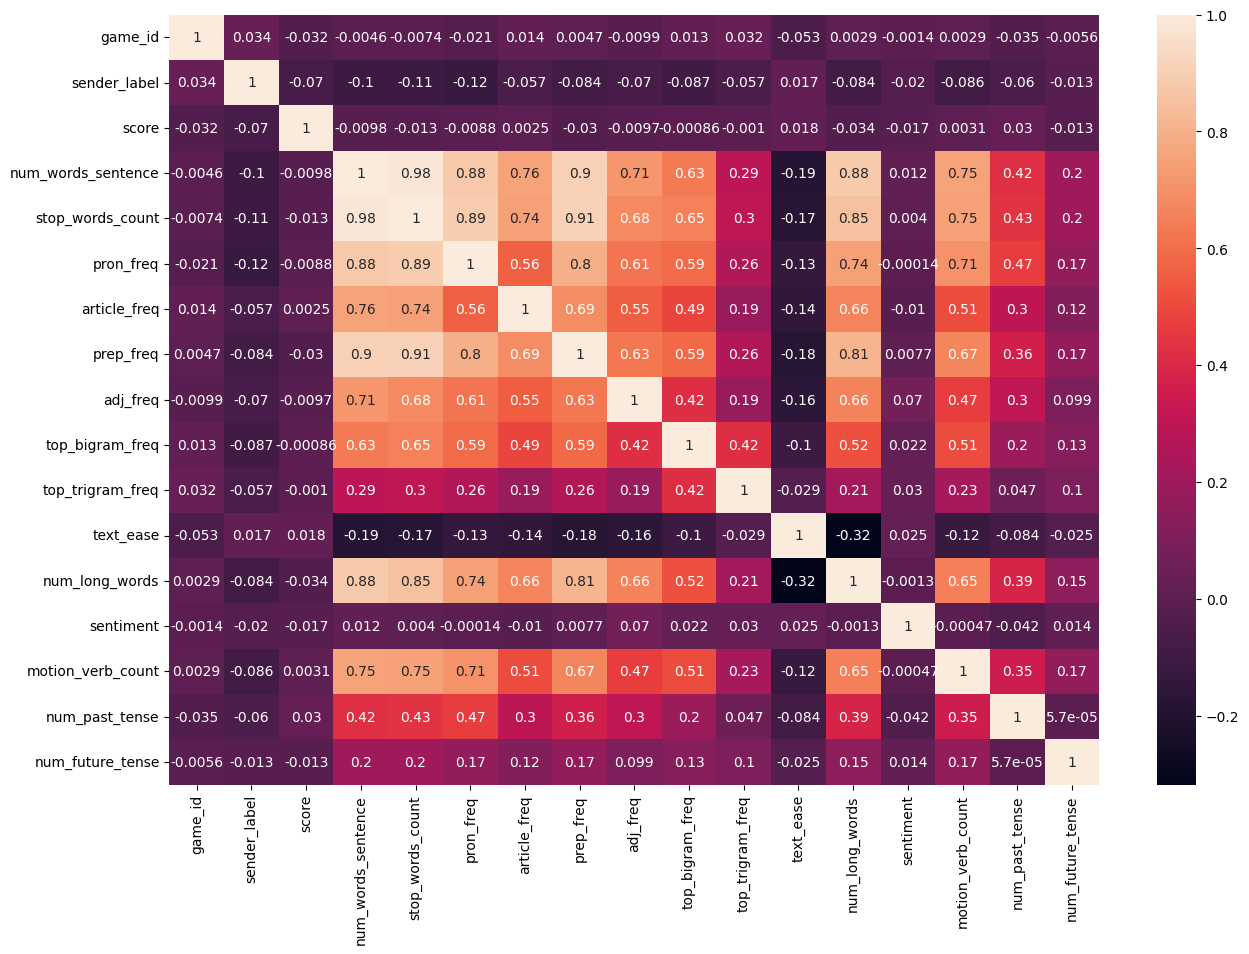

In [42]:
plt.figure(figsize=(15,10))
sns.heatmap(new_df.corr(),  annot=True)

---
#### save the proceesed dataframe into a file

In [43]:
new_df.to_json('data/processed_all.jsonl', orient='records', lines=True)

---
### Clustering

In [44]:
new_df['sender_label'] = new_df['sender_label'].astype(int)
value_map = {True: 1, False: 0, "NOANNOTATION": 2}  
new_df['receiver_label'] = new_df['receiver_label'].map(value_map)

In [45]:
clu_df = new_df.drop(['game_id'], axis = 1).select_dtypes(include='number')

In [46]:
clu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17289 entries, 0 to 17288
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sender_label        17289 non-null  int32  
 1   receiver_label      17289 non-null  int64  
 2   score               17289 non-null  int64  
 3   num_words_sentence  17289 non-null  int64  
 4   stop_words_count    17289 non-null  int64  
 5   pron_freq           17289 non-null  int64  
 6   article_freq        17289 non-null  int64  
 7   prep_freq           17289 non-null  int64  
 8   adj_freq            17289 non-null  int64  
 9   top_bigram_freq     17289 non-null  int64  
 10  top_trigram_freq    17289 non-null  int64  
 11  text_ease           17289 non-null  float64
 12  num_long_words      17289 non-null  int64  
 13  sentiment           17289 non-null  float64
 14  motion_verb_count   17289 non-null  int64  
 15  num_past_tense      17289 non-null  int64  
 16  num_

In [47]:
#vectorize the text

#vectorizer = TfidfVectorizer(stop_words='english')
#tfidf_matrix = vectorizer.fit_transform(new_df['processed_message'])
#tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
#clu_df = pd.concat([clu_df, tfidf_df], axis=1)

In [48]:
#feature_names = vectorizer.get_feature_names_out() 
#feature_names

In [49]:
#dimmensionality reduction
#from sklearn.decomposition import PCA
# initialize PCA
#pca = PCA()
#X_pca = pca.fit_transform(X)

#a PCA-like dimmensionality reduction that works on sparse data
svd = TruncatedSVD(n_components=5, random_state=42)
x_svd = svd.fit_transform(clu_df) 
# ignore dimentinality reduction for now

In [ ]:
for i, component in enumerate(svd.components_):
    component_with_feature = zip(feature_names, component)
    # Sort the features based on the absolute value of component coefficients
    most_important = sorted(component_with_feature, key=lambda x: np.abs(x[1]), reverse=True)
    print(f"Most important features for component {i + 1}:")
    for feature, value in most_important[:3]:  # print top 3; change the number here for more features
        print(f"{feature}: {value}")
    print()

In [ ]:
# normalise the data
#scaler = StandardScaler() 
#df_normalized = scaler.fit_transform(clu_df)

#### KMeans

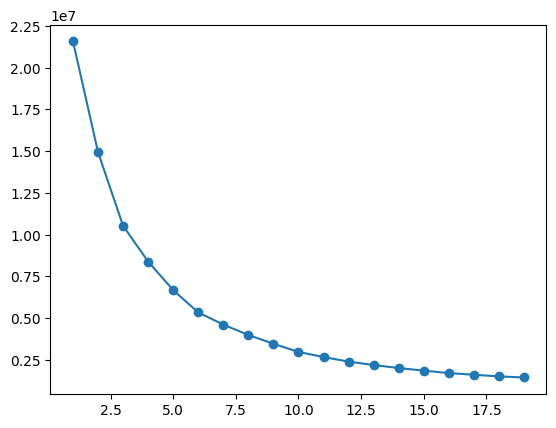

In [51]:
#determine the number of clusters -- elbow method
inertia = []
for i in range(1, 20):
    km = KMeans(n_clusters = i)
    #km.fit(x_svd)
    km.fit(clu_df)
    inertia.append(km.inertia_)
    
plt.plot(range(1, 20), inertia, marker='o' )

In [52]:
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
clusters = model.fit_predict(clu_df)

In [53]:
new_df['Kmeans_cluster'] = clusters
new_df[['num_long_words', 'Kmeans_cluster']]

,num_long_words,Kmeans_cluster
0,15,5
1,2,0
2,0,4
3,7,2
4,12,1
...,...,...
17284,17,5
17285,1,3
17286,1,3
17287,1,3


---
#### find the feature importance after clustering

In [54]:
def xgb_get_feature_importance(x,y):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)
    model.fit(X_train, y_train)

    #evaluate the model's accuracy to see how it performs
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # get feature importances
    feature_importances = model.feature_importances_
     # importances as a more interpretable series:
    importance_series = pd.Series(feature_importances, index=X.columns)
    # sort the features by importance
    sorted_importances = importance_series.sort_values(ascending=False)
    print(sorted_importances)

In [55]:
X = clu_df
y = new_df['Kmeans_cluster']  # target variable
xgb_get_feature_importance(X, y)
# maybe add sender and receiver labels as numeric to this too???

Accuracy: 99.39%
num_words_sentence    0.471798
text_ease             0.466688
stop_words_count      0.022637
num_long_words        0.006165
prep_freq             0.003674
sender_label          0.003568
pron_freq             0.003499
score                 0.003246
receiver_label        0.002756
num_past_tense        0.002481
sentiment             0.002313
adj_freq              0.002292
top_bigram_freq       0.002146
motion_verb_count     0.002112
num_future_tense      0.001783
top_trigram_freq      0.001476
article_freq          0.001365
dtype: float32


<Axes: xlabel='Kmeans_cluster', ylabel='text_ease'>

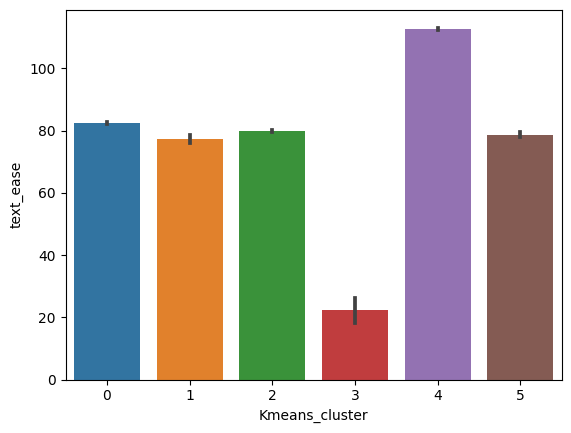

In [56]:
sns.barplot(x= new_df['Kmeans_cluster'], y = new_df['text_ease'])

<Axes: xlabel='Kmeans_cluster', ylabel='count'>

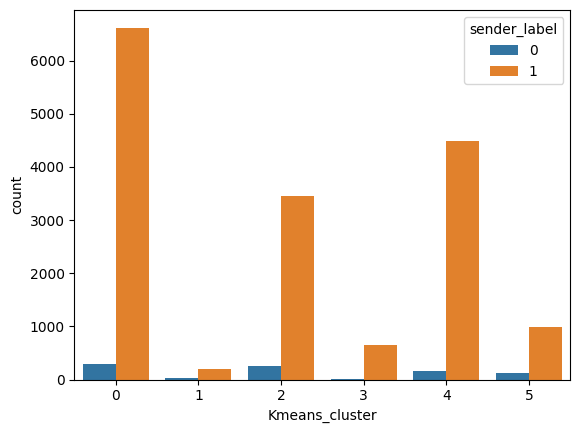

In [57]:
sns.countplot(x= new_df['Kmeans_cluster'], hue = new_df['sender_label'])

<Axes: xlabel='Kmeans_cluster', ylabel='count'>

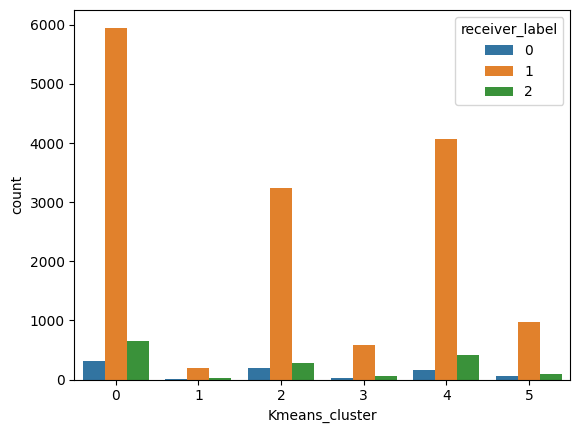

In [58]:
sns.countplot(x= new_df['Kmeans_cluster'], hue = new_df['receiver_label'])

In [59]:
# Internal eval: silhouette -> how similar an object is to its own cluster compared to other clusters
# higher the better(-1 to 1)
silhouette_avg = silhouette_score(clu_df, model.labels_)
print(f"Silhouette Score: {silhouette_avg}")
# Internal eval: Davies-Bouldin -> average similarity between clusters, that compares the distance between clusters with the size of the clusters
# lower score is better(0 to 1)
davies_score = davies_bouldin_score(clu_df, model.labels_)
print("Davies-Bouldin index:", davies_score)

Silhouette Score: 0.3626114827295456
Davies-Bouldin index: 0.8687866401000971


In [60]:
#centroids = model.cluster_centers_
#fig = plt.figure(figsize = (8,8))
#plt.scatter(new_df['text_ease'], new_df['num_words_sentence'], s=0.25)
#plt.scatter(centroids[:, 0], centroids[:, 1], marker = '*')

---
#### DBSCAN

In [61]:
dbscan = DBSCAN(eps=0.09, min_samples=10)

In [62]:
dbscan_clusters = dbscan.fit_predict(clu_df)

In [63]:
db_labels = dbscan.labels_
db_labels

array([-1, -1,  0, ..., -1, -1, -1], dtype=int64)

In [64]:
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)
n_clusters_

11

In [65]:
# Internal eval: silhouette -> how similar an object is to its own cluster compared to other clusters
# higher the better(-1 to 1)
silhouette_avg = silhouette_score(clu_df, db_labels)
print(f"Silhouette Score: {silhouette_avg}")
# Internal eval: Davies-Bouldin -> average similarity between clusters. compares the distance between clusters with the size of the clusters
# lower the better(0 to 1)
davies_score = davies_bouldin_score(clu_df, db_labels)
print("Davies-Bouldin index:", davies_score)

Silhouette Score: -0.034964275297141814
Davies-Bouldin index: 0.5545235817745873


In [66]:
new_df['dbscan_cluster'] = dbscan_clusters

<Axes: xlabel='dbscan_cluster', ylabel='count'>

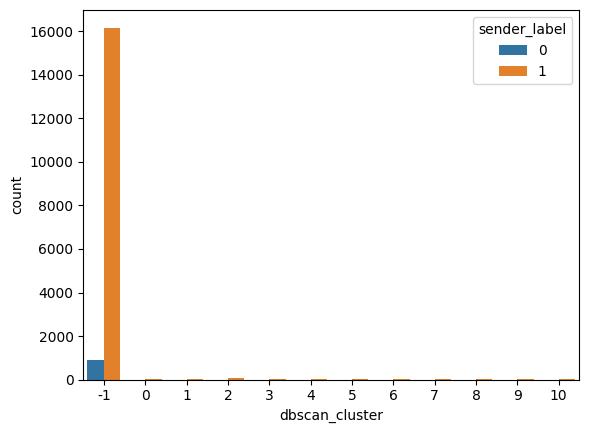

In [67]:
sns.countplot(x= new_df['dbscan_cluster'], hue = new_df['sender_label'])

<Axes: xlabel='dbscan_cluster', ylabel='count'>

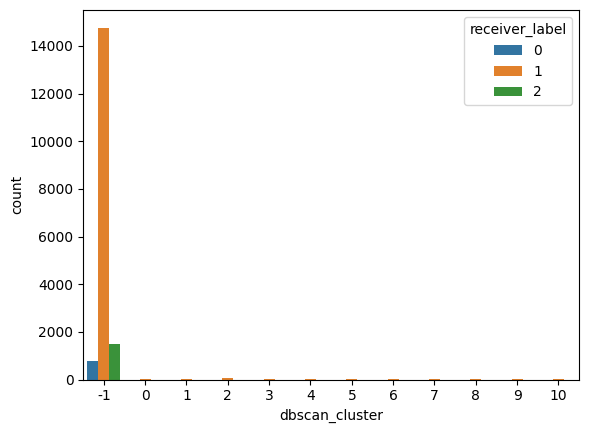

In [68]:
sns.countplot(x= new_df['dbscan_cluster'], hue = new_df['receiver_label'])

In [69]:
X = clu_df
y = new_df['dbscan_cluster']+1  # becouse dbscan labels starts from -1
xgb_get_feature_importance(X, y)

Accuracy: 99.97%
stop_words_count      0.161084
sentiment             0.160435
text_ease             0.134898
num_words_sentence    0.090331
score                 0.080406
receiver_label        0.071696
motion_verb_count     0.061567
pron_freq             0.050938
num_long_words        0.047955
sender_label          0.040422
num_past_tense        0.034440
prep_freq             0.033578
adj_freq              0.032250
top_trigram_freq      0.000000
top_bigram_freq       0.000000
article_freq          0.000000
num_future_tense      0.000000
dtype: float32


In [70]:
#fig = plt.figure(figsize=(5,5))
#plt.scatter(new_df['text_ease'], new_df['stop_words_coun'], c=db_labels, s=20, cmap='rainbow')